In [1]:
import pandas as pd
import json
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import venn
import numpy as np
from numpy.random import seed
from numpy.random import randint

# Bot contributors

1. Ground truth dataset used for training Bodegha bot identification tool

In [2]:
Golzadeh_et_al = pd.read_csv('', index_col = 0)
Golzadeh_et_al_bot = Golzadeh_et_al.query('type =="Bot"').reset_index()
Golzadeh_et_al_bot.sort_values('account')

,account,project,type
48,0crat,zold-io/zold,Bot
282,42bot,42BV/ui,Bot
161,5iMON-bot,system76/web-eslint-config,Bot
193,AgoricBot,Agoric/make-hardener,Bot
152,ApiaryBot,apiaryio/gavel-spec,Bot
...,...,...,...
392,z-docker-bot,Zenika/docker-kotlin,Bot
219,zaripych-bot,zaripych/node-op,Bot
101,zcabot,zeroc-ice/ice,Bot
508,zeebe-bors,zeebe-io/zeebe,Bot


2. Ground truth dataset used for training BotHunter bot identification tool

In [3]:
Abdellatif_at_al = pd.read_csv('', index_col = 0)
Abdellatif_at_al_bot = Abdellatif_at_al.rename(columns = {'Type': 'type'}).query('type == "Bot"')
Abdellatif_at_al_bot.sort_values('account')

,account,type
42,0crat,Bot
564,24emebot,Bot
279,42bot,Bot
168,5iMON-bot,Bot
196,AgoricBot,Bot
...,...,...
387,z-docker-bot,Bot
220,zaripych-bot,Bot
113,zcabot,Bot
676,zeit-github-tester[bot],Bot


3. Ground truth dataset used by Chidambaram et al. for bot analysis

In [4]:
Chidambaram_et_al = pd.read_csv('', index_col = 0)
Chidambaram_et_al_bot = Chidambaram_et_al.rename(columns = {'ground_truth': 'type'}).query('type == "Bot"')
Chidambaram_et_al_bot.sort_values('account')

,account,type
1,AppVeyorBot,Bot
8,CLAassistant,Bot
17,GitCop,Bot
0,allcontributors,Bot
2,azure-pipelines,Bot
3,bors,Bot
4,cargo-dep-bot,Bot
5,cla-bot,Bot
6,cla-bot-2020,Bot
7,cla-bot-2021,Bot


4. Ground truth dataset used by Wang et al. for bot activities analysis 

In [5]:
Wang_at_al = pd.read_csv('', index_col = 0)
Wang_at_al_bot = Wang_at_al.query('type == "bot"')
Wang_at_al_bot.sort_values('account')

,account,type
107,AmplabJenkins,bot
78,AppVeyor,bot
79,AppVeyorBot,bot
80,Azure-pipelines,bot
9,Boring-Cyborg,bot
...,...,...
74,welcome,bot
102,whitesource-for-github-com,bot
228,yahoocla,bot
75,yii-bot,bot


## Data cleaning
1. Combine all the datasets
2. Remove [bot] suffix if it exisits
3. Remove duplicates in account

In [6]:
all_bots = pd.concat([Golzadeh_et_al_bot, Abdellatif_at_al_bot, Chidambaram_et_al_bot, Wang_at_al_bot])
all_bots['account_upd'] = all_bots['account'].str.replace("\\[bot]", '', regex=True)
all_bots = all_bots.drop_duplicates('account_upd')
all_bots.sort_values('account')

,account,project,type,account_upd
48,0crat,zold-io/zold,Bot,0crat
564,24emebot,NaN,Bot,24emebot
282,42bot,42BV/ui,Bot,42bot
161,5iMON-bot,system76/web-eslint-config,Bot,5iMON-bot
193,AgoricBot,Agoric/make-hardener,Bot,AgoricBot
...,...,...,...,...
508,zeebe-bors,zeebe-io/zeebe,Bot,zeebe-bors
676,zeit-github-tester[bot],NaN,Bot,zeit-github-tester
677,zenossbot,NaN,Bot,zenossbot
289,zorro-bot,NG-ZORRO/ng-zorro-antd,Bot,zorro-bot


## Query GitHub users API

In [7]:
QUERY_ROOT = "https://api.github.com"
query_session = requests.Session()
query_session.auth = ('', '') # place your github username and token within the quotes (E.g., ('<username>', '<token>'))

In [8]:
def account_info(login_name, info_dict):
    query = f'{QUERY_ROOT}/users/{login_name}'
    response = query_session.get(query)
    if response.ok:
        json_response = response.json()
        if not json_response:
            info_dict['login_name'] = None
            info_dict['type_API'] = None
            info_dict['account_url'] = None
            return(info_dict)
        
        info_dict['login_name'] = login_name
        info_dict['type_API'] = json_response['type']
        info_dict['account_url'] = json_response['html_url']
    return(info_dict, response)

## Two types of accounts
1. GitHub app - has '[bot]' in its suffix
2. Classical bot - GitHub account but a bot

First check if the account belongs to GitHub app by adding '[bot]' suffix to its name. If it does not exist, then search for the account existence as a GitHub account by keeping the name as it is

In [9]:
bot_accounts = all_bots['account_upd'].to_list()

account_type_list = []
for login_name in tqdm(bot_accounts): #hum_accounts, #bot_accounts
    
    info_dict = {}
    login_name_bot = f'{login_name}[bot]'
    info_dict['account'] = login_name_bot
    info_dict_upd, response = account_info(login_name_bot, info_dict)
    
    if(not(response)):
        info_dict['account'] = login_name
        info_dict_try, response = account_info(login_name, info_dict)
        if(response):
            info_dict_upd = info_dict_try

    account_type_list.append(info_dict_upd)

df_acc = pd.DataFrame.from_dict(account_type_list, orient = 'columns')

100%|██████████| 890/890 [04:33<00:00,  3.26it/s]


In [13]:
df_acc.sort_values('account')

,account,login_name,type_API,account_url
48,0crat,0crat,User,https://github.com/0crat
631,24emebot,24emebot,User,https://github.com/24emebot
282,42bot,42bot,User,https://github.com/42bot
161,5iMON-bot,5iMON-bot,User,https://github.com/5iMON-bot
193,AgoricBot,AgoricBot,User,https://github.com/AgoricBot
...,...,...,...,...
508,zeebe-bors[bot],zeebe-bors[bot],Bot,https://github.com/apps/zeebe-bors
740,zeit-github-tester[bot],zeit-github-tester[bot],Bot,https://github.com/apps/zeit-github-tester
741,zenossbot,zenossbot,User,https://github.com/zenossbot
289,zorro-bot[bot],zorro-bot[bot],Bot,https://github.com/apps/zorro-bot


In [14]:
df_acc_type_bot = df_acc.query('type_API == "Bot"')
df_acc_type_user = df_acc.query('type_API == "User"')

print('{0} accounts have their type as User by API'.format(df_acc_type_user.shape[0]))

print('{0} accounts have their type as Bot by API'.format(df_acc_type_bot.shape[0]))

685 accounts have their type as User by API
167 accounts have their type as Bot by API


In [15]:
pd.concat([df_acc_type_bot,df_acc_type_user]).to_csv('GroundTruthData/BotAccounts.csv')

## Identifying the distribution of accounts among 4 datasets

In [16]:
#accounts with [bot] as suffix are present only in Abdellatif_et_al.csv
accounts = pd.read_csv('GroundTruthData/BotAccounts.csv', index_col=0)
accounts['account'] = accounts['account'].str.replace('\\[bot]','',regex=True)
Abdellatif_et_al_upd = pd.read_csv('',index_col=0).query('Type == "Bot"')
Abdellatif_et_al_upd['account'] = Abdellatif_et_al_upd['account'].str.replace('\\[bot]','',regex=True)

In [17]:
Golzadeh_et_al_acc_url = Golzadeh_et_al.merge(accounts, on = 'account', how = 'inner')
Chidambaram_et_al_acc_url = Chidambaram_et_al.merge(accounts, on = 'account', how = 'inner')
Abdellatif_et_al_acc_url = Abdellatif_et_al_upd.merge(accounts, on = 'account', how = 'inner')
Wang_et_al_acc_url = Wang_at_al_bot.merge(accounts, on = 'account', how = 'inner')

In [18]:
Golzadeh_et_al_acc = Golzadeh_et_al_acc_url['account_url'].to_list()
Chidambaram_et_al_acc = Chidambaram_et_al_acc_url['account_url'].to_list()
Abdellatif_et_al_acc = Abdellatif_et_al_acc_url['account_url'].to_list()
Wang_et_al_acc = Wang_et_al_acc_url['account_url'].to_list()
print(len(Golzadeh_et_al_acc), 
      len(Chidambaram_et_al_acc), 
      len(Abdellatif_et_al_acc), 
      len(Wang_et_al_acc))

507 36 665 217


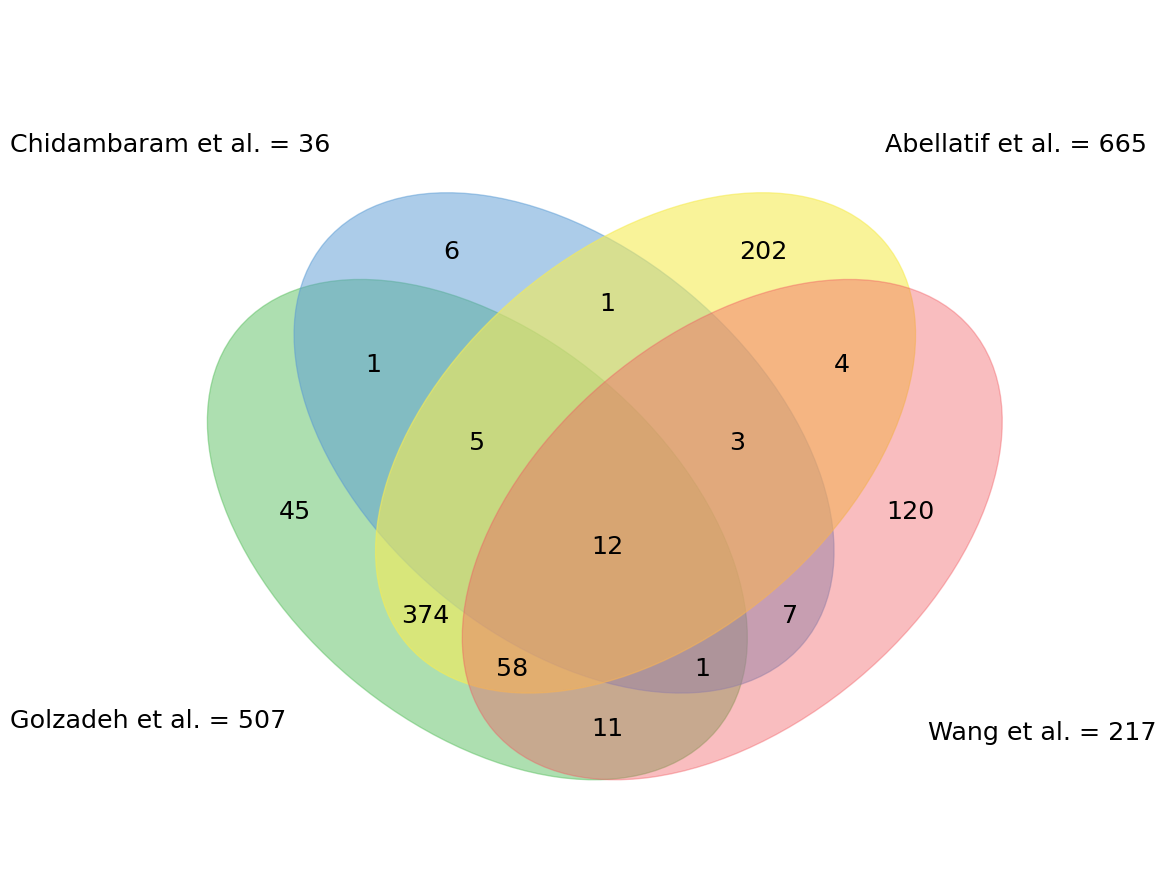

In [19]:
labels = venn.get_labels([Golzadeh_et_al_acc, Chidambaram_et_al_acc, Abdellatif_et_al_acc, Wang_et_al_acc], fill=['number'])
fig, ax = venn.venn4(labels, names=[f'Golzadeh et al. = {len(Golzadeh_et_al_acc)}', 
                                    f'Chidambaram et al. = {len(Chidambaram_et_al_acc)}',
                                    f'Abellatif et al. = {len(Abdellatif_et_al_acc)}',
                                    f'Wang et al. = {len(Wang_et_al_acc)}'],
                     fontsize=19)
plt.tight_layout()
fig.savefig('Images/vennDiagram4Datasets.pdf')

# Human accounts

1. Ground truth dataset used for training Bodegha bot identification tool

In [20]:
Golzadeh_et_al = pd.read_csv('', index_col = 0)
Golzadeh_et_al_human = Golzadeh_et_al.query('type =="Human"').reset_index()
print(Golzadeh_et_al_human.shape[0])

4473


2. Ground truth dataset used for training BotHunter bot identification tool

In [21]:
Abdellatif_at_al = pd.read_csv('', index_col = 0)
Abdellatif_at_al_human = Abdellatif_at_al.query('Type == "Human"')
print(Abdellatif_at_al_human.shape[0])

4428


1. Joining both the datsets and removing duplicates based on account
2. Sampling accounts from the list of humans

In [22]:
all_humans = pd.concat([Golzadeh_et_al_human, Abdellatif_at_al_human]).drop_duplicates('account')

seed(seed = 1)
rand_hum = np.random.choice(4473, 750, replace=False)
hum_acc = all_humans.iloc[rand_hum]
hum_acc = hum_acc.sort_index()

Querying GitHub Users API to know if an account exists or not

In [23]:
hum_accounts = hum_acc['account'].to_list()
account_type_list = []
for login_name in tqdm(hum_accounts): #hum_accounts, #bot_accounts
    
    info_dict = {}
    info_dict['account'] = login_name
    info_dict_upd, response = account_info(login_name, info_dict)
    account_type_list.append(info_dict_upd)

df_hum_acc = pd.DataFrame.from_dict(account_type_list, orient = 'columns')

100%|██████████| 750/750 [02:10<00:00,  5.76it/s]


In [24]:
df_acc_type_hum = df_hum_acc[df_hum_acc['account_url'].notnull()].drop_duplicates('account_url')
print(df_acc_type_hum.shape[0])

736
